# [NTDS'18] Final Project: Senator vote predictions based on graph features

## Students

* Team: `7`
* Students: `Mathias Gonçalves, Julien Heitmann, Mathieu Lamiot, Louis Landelle`
* Dataset: `US Senators`

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

#Import distances
from scipy.spatial.distance import squareform

from scipy import sparse
import scipy.sparse.linalg

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from pyunlocbox import functions, solvers
import networkx as nx

import common

## 0 - Loading the data

All the data we load here was retrieved in the first milestone thanks to the dedicated API. Using this API takes some times, hence it is not repeated here and we simply load previously saved files.

* "senators"
* "adjacency" 
* "cosponsored" 
* "DFvote_positions" 
* "DFvotes"

In [2]:
senators = np.load(common.ACTIVE_SENATORS_FNAME)
adjacency = np.load(common.ADJACENCY_FNAME)
cosponsored = pd.read_pickle(common.COSPONSORED_FNAME)
DFvote_positions = pd.read_pickle(common.VOTE_POSITIONS_FNAME)
DFvotes = pd.read_pickle(common.VOTES_FNAME).set_index("id") #explain
DFsenators = pd.DataFrame.from_records(senators).set_index("id") #explain

### Indices ###
vote_ids = DFvotes.index.values
senator_ids = DFsenators.index.values

In [3]:
with open(common.COSPONSORS_FNAME, "rb") as ser_dict:
    cosponsors = pickle.load(ser_dict)

In [4]:
#Convert features to numbers
DFvote_positions = DFvote_positions.replace('Yes',1)
DFvote_positions = DFvote_positions.replace('No',0)

#All others values should be NaN
DFvote_positions = DFvote_positions.apply(pd.to_numeric, errors='coerce')

### Diplay data

In [5]:
senators[:2]

array([{'id': 'A000360', 'title': 'Senator, 2nd Class', 'short_title': 'Sen.', 'api_uri': 'https://api.propublica.org/congress/v1/members/A000360.json', 'first_name': 'Lamar', 'middle_name': None, 'last_name': 'Alexander', 'suffix': None, 'date_of_birth': '1940-07-03', 'gender': 'M', 'party': 'R', 'leadership_role': None, 'twitter_account': 'SenAlexander', 'facebook_account': 'senatorlamaralexander', 'youtube_account': 'lamaralexander', 'govtrack_id': '300002', 'cspan_id': '5', 'votesmart_id': '15691', 'icpsr_id': '40304', 'crp_id': 'N00009888', 'google_entity_id': '/m/01rbs3', 'fec_candidate_id': 'S2TN00058', 'url': 'https://www.alexander.senate.gov/public', 'rss_url': 'https://www.alexander.senate.gov/public/?a=RSS.Feed', 'contact_form': 'http://www.alexander.senate.gov/public/index.cfm?p=Email', 'in_office': True, 'dw_nominate': 0.323, 'ideal_point': None, 'seniority': '15', 'next_election': '2020', 'total_votes': 569, 'missed_votes': 26, 'total_present': 0, 'last_updated': '2018-11

In [6]:
DFvote_positions[DFvote_positions.columns[::-1]] #reverse column order, most recent votes first

,C115:S2:C99,C115:S2:C98,C115:S2:C97,C115:S2:C96,C115:S2:C95,C115:S2:C94,C115:S2:C93,C115:S2:C92,C115:S2:C91,C115:S2:C90,...,C111:S2:C109,C111:S2:C108,C111:S2:C107,C111:S2:C106,C111:S2:C105,C111:S2:C104,C111:S2:C103,C111:S2:C102,C111:S2:C101,C111:S2:C100
0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,0.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
DFvotes

,amendment.api_uri,amendment.number,amendment.sponsor,amendment.sponsor_id,amendment.sponsor_party,amendment.sponsor_state,amendment.sponsor_uri,bill.bill_id,bill.bill_uri,bill.latest_action,...,question,result,roll_call,session,time,total.no,total.not_voting,total.present,total.yes,vote_uri
id,,,,,,,,,,,,,,,,,,,,,
C115:S2:C274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hr695-115,https://api.propublica.org/congress/v1/115/bil...,Considered by Senate (Message from the House c...,...,On the Motion to Proceed,Motion to Proceed Agreed to,274,2,12:31:00,47,6,0,47,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hr695-115,https://api.propublica.org/congress/v1/115/bil...,Considered by Senate (Message from the House c...,...,On the Motion,Motion Agreed to,273,2,21:30:00,21,8,0,71,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pn2209-115,NaN,NaN,...,On the Cloture Motion,Cloture Motion Agreed to,272,2,11:22:00,1,4,0,95,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Motion,Motion Agreed to,271,2,20:22:00,12,1,0,87,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C270,https://api.propublica.org/congress/v1/115/ame...,S.Amdt. 4109 to S.Amdt. 4108,John Kennedy,K000393,R,La.,https://api.propublica.org/congress/v1/members...,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Amendment,Amendment Rejected,270,2,20:02:00,62,1,0,37,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C269,https://api.propublica.org/congress/v1/115/ame...,S.Amdt. 4109 to S.Amdt. 4108,John Kennedy,K000393,R,La.,https://api.propublica.org/congress/v1/members...,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Amendment,Amendment Rejected,269,2,19:43:00,66,1,0,33,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C268,https://api.propublica.org/congress/v1/115/ame...,S.Amdt. 4109 to S.Amdt. 4108,John Kennedy,K000393,R,La.,https://api.propublica.org/congress/v1/members...,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Amendment,Amendment Rejected,268,2,19:01:00,67,1,0,32,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Cloture Motion,Cloture Motion Agreed to,267,2,17:22:00,12,6,0,82,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sjres54-115,https://api.propublica.org/congress/v1/115/bil...,Held at the desk.,...,On the Joint Resolution,Joint Resolution Passed,266,2,15:03:00,41,3,0,56,https://api.propublica.org/congress/v1/115/sen...


In [8]:
DFsenators

,api_uri,contact_form,crp_id,cspan_id,date_of_birth,dw_nominate,facebook_account,fax,fec_candidate_id,first_name,...,state_rank,suffix,title,total_present,total_votes,twitter_account,url,votes_with_party_pct,votesmart_id,youtube_account
id,,,,,,,,,,,,,,,,,,,,,
A000360,https://api.propublica.org/congress/v1/members...,http://www.alexander.senate.gov/public/index.c...,N00009888,5,1940-07-03,0.323,senatorlamaralexander,202-228-3398,S2TN00058,Lamar,...,senior,None,"Senator, 2nd Class",0,569,SenAlexander,https://www.alexander.senate.gov/public,97.05,15691,lamaralexander
B001230,https://api.propublica.org/congress/v1/members...,https://www.baldwin.senate.gov/feedback,N00004367,57884,1962-02-11,-0.522,TammyBaldwin,202-225-6942,S2WI00219,Tammy,...,junior,None,"Senator, 1st Class",1,569,SenatorBaldwin,https://www.baldwin.senate.gov,94.17,3470,witammybaldwin
B001261,https://api.propublica.org/congress/v1/members...,https://www.barrasso.senate.gov/public/index.c...,N00006236,1024777,1952-07-21,0.533,johnbarrasso,202-224-1724,S6WY00068,John,...,junior,None,"Senator, 1st Class",0,569,SenJohnBarrasso,https://www.barrasso.senate.gov,96.65,52662,barrassowyo
B001267,https://api.propublica.org/congress/v1/members...,https://www.bennet.senate.gov/?p=contact,N00030608,1031622,1964-11-28,-0.207,senbennetco,202-228-5097,S0CO00211,Michael,...,senior,None,"Senator, 3rd Class",1,569,SenBennetCo,https://www.bennet.senate.gov,90.25,110942,SenatorBennet
B001277,https://api.propublica.org/congress/v1/members...,https://www.blumenthal.senate.gov/contact/,N00031685,21799,1946-02-13,-0.423,SenBlumenthal,202-224-9673,S0CT00177,Richard,...,senior,None,"Senator, 3rd Class",1,569,SenBlumenthal,https://www.blumenthal.senate.gov,90.81,1568,SenatorBlumenthal
B000575,https://api.propublica.org/congress/v1/members...,https://www.blunt.senate.gov/public/index.cfm/...,N00005195,45465,1950-01-10,0.430,SenatorBlunt,202-224-8149,S0MO00183,Roy,...,junior,None,"Senator, 3rd Class",0,569,RoyBlunt,https://www.blunt.senate.gov/public,98.20,418,SenatorBlunt
B001288,https://api.propublica.org/congress/v1/members...,https://www.booker.senate.gov/?p=contact,N00035267,84679,1969-04-27,-0.612,None,202-224-8378,S4NJ00185,Cory,...,junior,None,"Senator, 2nd Class",1,569,CoryBooker,https://www.booker.senate.gov,84.10,76151,SenCoryBooker
B001236,https://api.propublica.org/congress/v1/members...,https://www.boozman.senate.gov/public/index.cf...,N00013873,92069,1950-12-10,0.401,JohnBoozman,202-228-1371,S0AR00150,John,...,senior,None,"Senator, 3rd Class",0,569,JohnBoozman,https://www.boozman.senate.gov/public,98.23,27958,BoozmanPressOffice
B000944,https://api.propublica.org/congress/v1/members...,http://www.brown.senate.gov/contact/,N00003535,5051,1952-11-09,-0.438,None,202-228-6321,S6OH00163,Sherrod,...,senior,None,"Senator, 1st Class",1,569,SenSherrodBrown,https://www.brown.senate.gov,93.47,27018,SherrodBrownOhio


## 1 - First Feature: 2nd Laplacian eigenvector

In the following, we summarize what we found out during milestone 3. Laplacian eigenmaps of the network based on the votes of each senators provides a nice way of clustering senators that can be interpreted as their party. As we will see, it provides a powerful feature for our classifier as it already achieves good performances with only one feature coming from the 2nd dimension of the Laplacian eigenmaps.

First, let's review the graph we will use in this section. Each node is a senator and edges/weights are generated from 'DFvote_positions': for each pair of senator, we computed a distance based on their votes in common (cf. milestone 1). The graph we obtained is the presented below. It is strongly clustered into two parts, that are actually the parties (democrats and republicans).

C:\Users\agadg\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


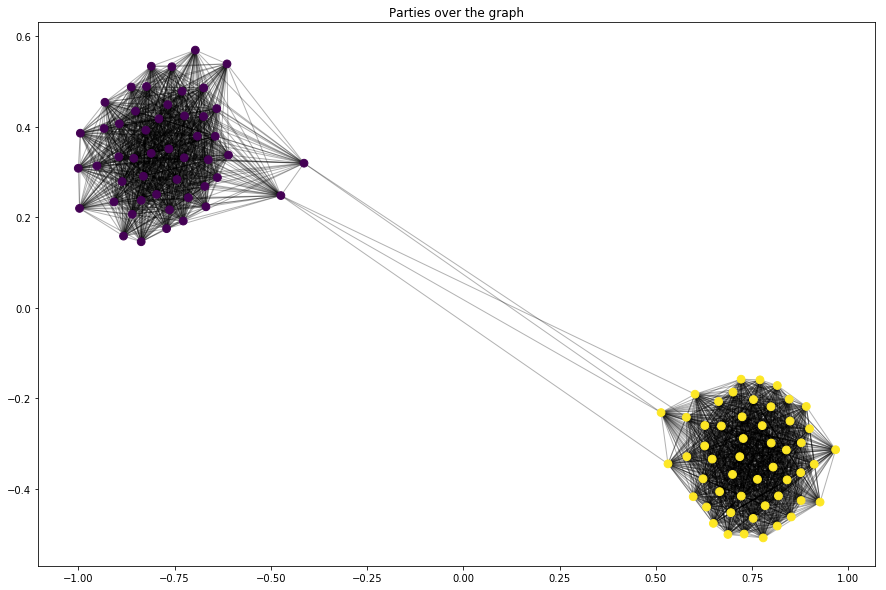

In [9]:
party = np.array([s["party"] for s in senators])
party_for_graph = (((party == 'R')*1)-0.5)*2

#Display the graph and the parties
graph = nx.from_scipy_sparse_matrix(scipy.sparse.csr_matrix(adjacency))
coords = nx.spring_layout(graph)  # Force-directed layout.
plt.figure(figsize= (15,10))
plt.subplot(111)
plt.title("Parties over the graph")
nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=party_for_graph)
nx.draw_networkx_edges(graph, coords, alpha=0.3)

Even if Republicans/Democrats could be a good feature to begin with, it seems that some senators are strongly coherent with their party whereas some other are a bit "in-between". Hence, a binary feature might not capture exactly the phenomenon.

In order to get a good measure of affiliation with the party, we will have a deeper look into the laplacian eigenmaps, as suggested in milestone 3.

In [10]:
# Create the Laplacian
degree_vect = np.sum(adjacency,axis=1)
degree_matrix = np.diag(degree_vect)
laplacian = degree_matrix-adjacency
laplacian_csr = sparse.csr_matrix(laplacian)
# Compute eigenvectors using sparse laplacian - Missing the last eigenvalue
d = 8
eig_val, eig_vect = sparse.linalg.eigsh(laplacian_csr, k=d, which = 'SM')
fiedler = eig_vect.T[1] # Fiedler vector

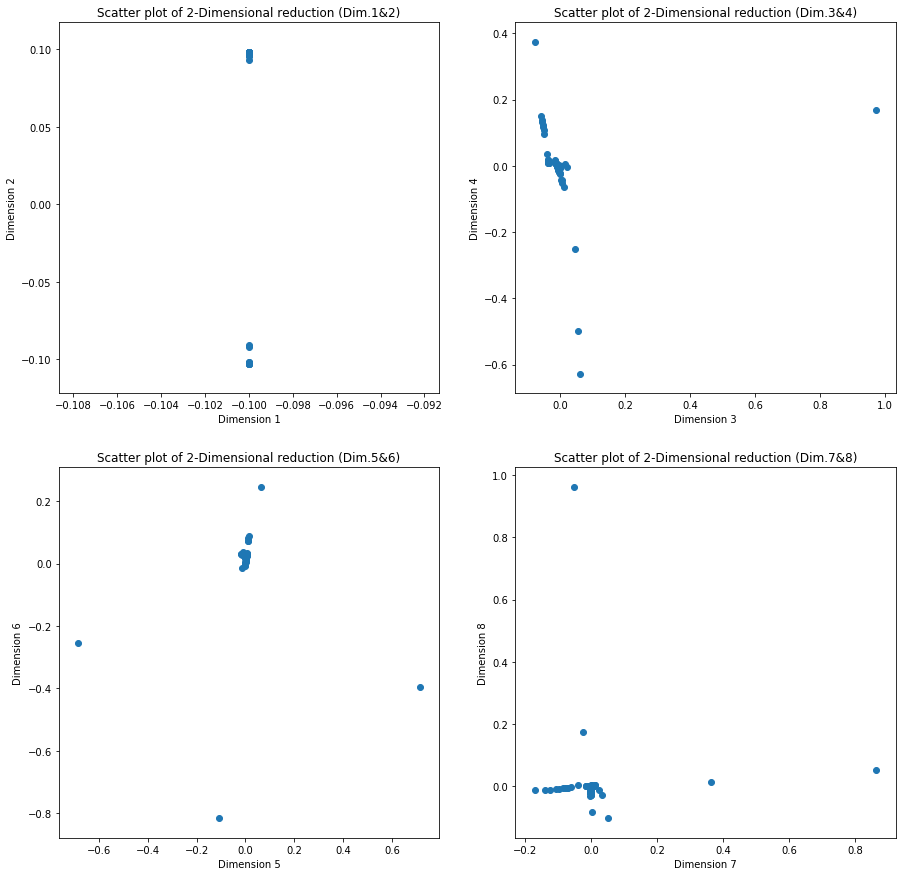

In [11]:
plt.figure(figsize= (15,15))
plt.subplot(221)
plt.scatter(eig_vect[:,0], eig_vect[:,1])
plt.title("Scatter plot of 2-Dimensional reduction (Dim.1&2)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")


plt.subplot(222)
plt.scatter(eig_vect[:,2], eig_vect[:,3])
plt.title("Scatter plot of 2-Dimensional reduction (Dim.3&4)")
plt.xlabel("Dimension 3")
plt.ylabel("Dimension 4")

plt.subplot(223)
plt.scatter(eig_vect[:,4], eig_vect[:,5])
plt.title("Scatter plot of 2-Dimensional reduction (Dim.5&6)")
plt.xlabel("Dimension 5")
plt.ylabel("Dimension 6")

plt.subplot(224)
plt.scatter(eig_vect[:,6], eig_vect[:,7])
plt.title("Scatter plot of 2-Dimensional reduction (Dim.7&8)")
plt.xlabel("Dimension 7")
plt.ylabel("Dimension 8")
plt.show()

As we can see, the dimensions 2, 4 and 7 seem to be the most relevant to separate the senators. Other dimensions lead to the separation of one (or a couple) of senators only which means they are likely not to be useful. Let's see if those three dimensions are actually useful.
We add to the following plots colors depending on the party of each senator (republicans and democrats) to try and interpret those dimensions.

Text(0, 0.5, 'Dimension 7')

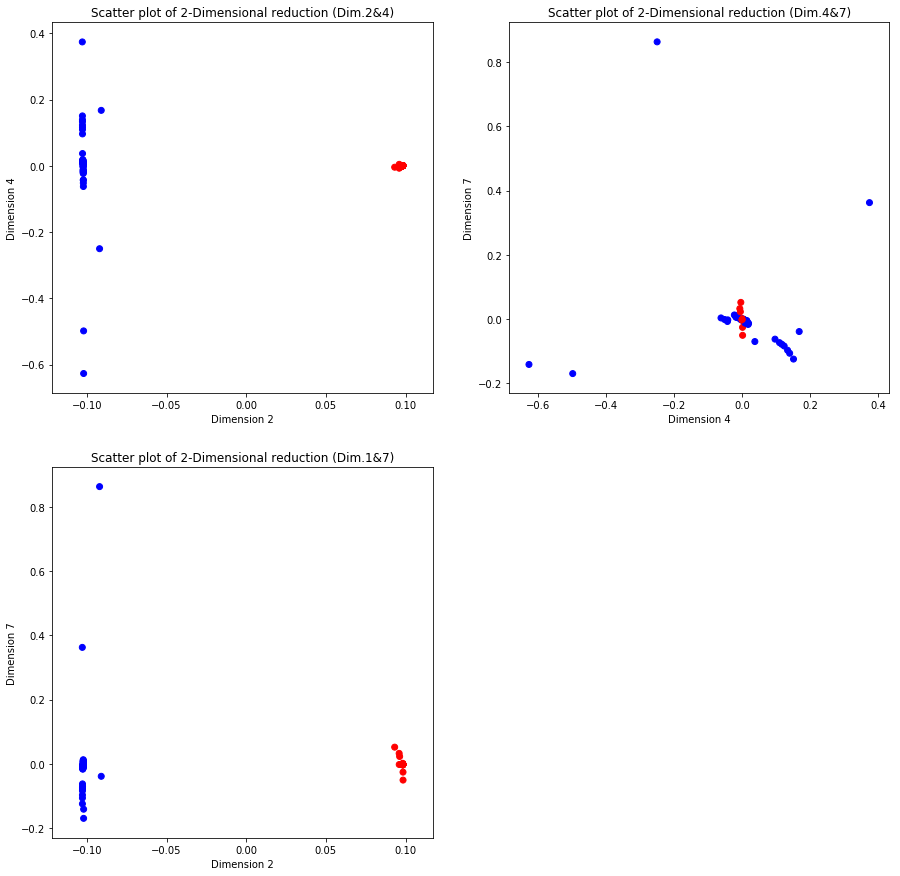

In [12]:
#Generate a colormap based on the party of each senator
color_map = np.repeat('b', party.size)
color_map[party == 'R'] = 'r'


plt.figure(figsize= (15,15))
plt.subplot(221)
plt.scatter(eig_vect[:,1], eig_vect[:,3],c=color_map)
plt.title("Scatter plot of 2-Dimensional reduction (Dim.2&4)")
plt.xlabel("Dimension 2")
plt.ylabel("Dimension 4")


plt.subplot(222)
plt.scatter(eig_vect[:,3], eig_vect[:,6],c=color_map)
plt.title("Scatter plot of 2-Dimensional reduction (Dim.4&7)")
plt.xlabel("Dimension 4")
plt.ylabel("Dimension 7")


plt.subplot(223)
plt.scatter(eig_vect[:,1], eig_vect[:,6],c=color_map)
plt.title("Scatter plot of 2-Dimensional reduction (Dim.1&7)")
plt.xlabel("Dimension 2")
plt.ylabel("Dimension 7")

Dimensions 4 and 7 seem to seperate only a few senators from the others, hence they are probably not a useful general feature. Notice that dimension 2 is strongly linked to the party of the senator and separate republicans from democrats. Hence, this dimension is particularly interesting as it can be easily interpreted. No specific interpretations were found for the other dimensions.
Thanks to this observation, we will use dimension 2 as a feature for our classifier: As each vote is introduced by a person affiliated to a party, our feature will be the distance of a senator to the party linked to the vote (Republican = 0.1, Democrats = -0.1) along that 2nd dimension of the eigenmaps.

In [13]:
def feature_laplacian_eigen_dim2(fiedler, df_votes, senator_id_num, vote_id):
    
    #Retrieve the feature of the senator
    senatorLoc = fiedler[senator_id_num]
    voteParty = df_votes.loc[vote_id, "amendment.sponsor_party"]
    
    if voteParty == 'D':
        voteLoc = -0.1
        #print("D")
    elif voteParty[0] == 'R':
        voteLoc = 0.1
        #print("R")
    else:
        voteLoc = senatorLoc #In this case, we want the feature not to count
    
    #Compute the distance between the two features to be used as a new feature
    distance = abs(voteLoc-senatorLoc)
    
    return distance 

## 2 - Second feature: Cosponsorship 

In [14]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection / union)

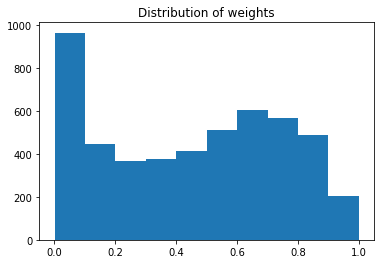

In [15]:
#Generate a graph based on cosponsored bills
n_senators = len(senators)
cospons_mat = np.zeros((n_senators, n_senators))

#Compute the weights between senators: a distance based on the cosponsorship feature
senator_pairs = ((i, j, x, y) for i, x in enumerate(senators) for j, y in enumerate(senators) if not x["id"] == y["id"])

for i, j, s1, s2 in senator_pairs:
    
    #common_bills = set(cosponsored[s1["id"]]).intersection(cosponsored[s2["id"]])
    #commonality = len(common_bills) / 20. 
    commonality = jaccard_similarity(cosponsored[s1["id"]], cosponsored[s2["id"]])
    cospons_mat[i, j] = commonality
    cospons_mat[j, i] = commonality

#From the feature differences, build distances and weights    
cospons_vect = squareform(cospons_mat)
kernel_width = cospons_vect.mean()
weights_vect = np.exp(-cospons_vect**2 / kernel_width**2)

#Visualize the weights distribution to assign a treshold
plt.hist(weights_vect)
plt.title('Distribution of weights')
plt.show()

C:\Users\agadg\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


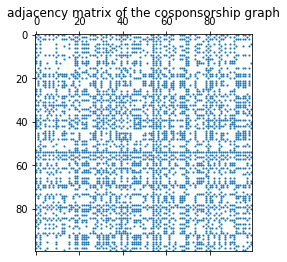

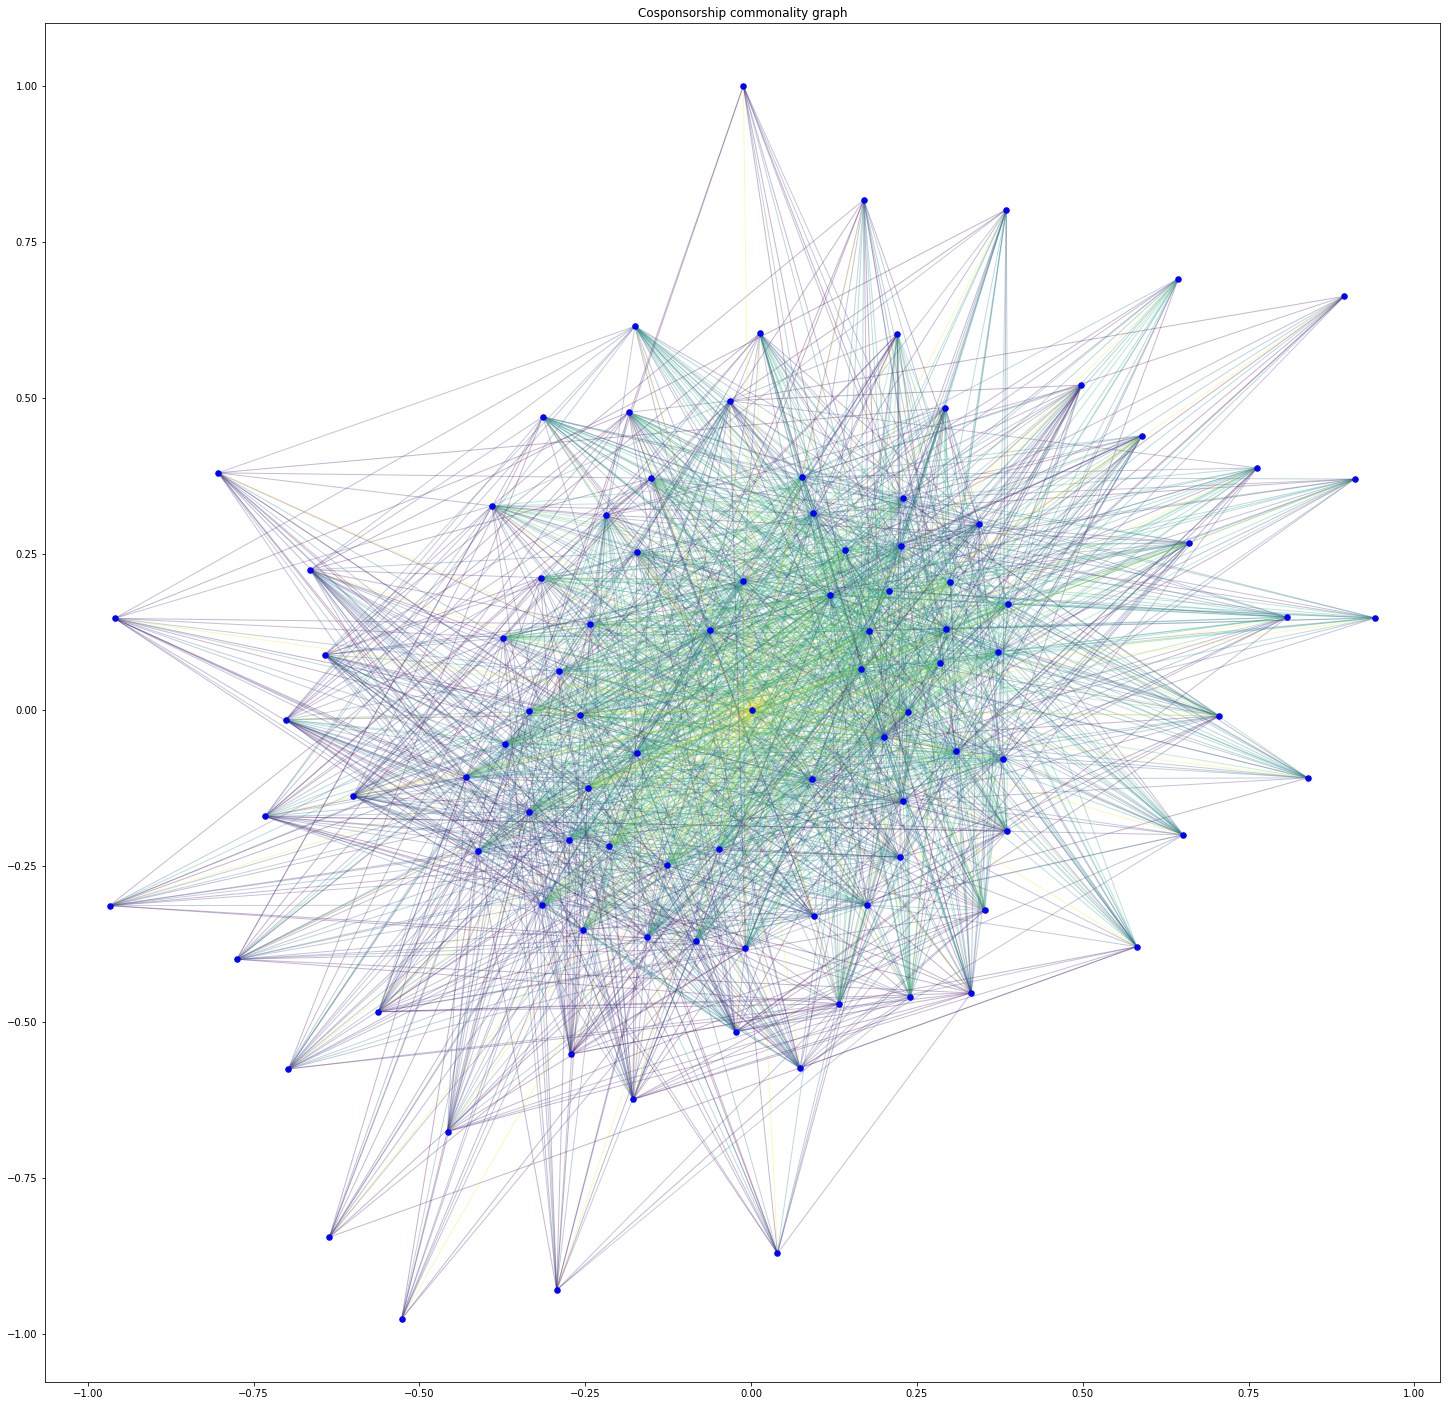

In [16]:
#Treshold the matrix
weights_threshold = 0.6
adjacency_cospons = squareform(weights_vect)
adjacency_cospons[adjacency_cospons < weights_threshold] = 0 

#Display
plt.spy(adjacency_cospons, markersize=1)
plt.title('adjacency matrix of the cosponsorship graph')

graph_cospons = nx.from_numpy_matrix(adjacency_cospons)
#coords_cospons = nx.circular_layout(graph_cospons)
coords_cospons = nx.spring_layout(graph_cospons)

_, weights_cospons = zip(*nx.get_edge_attributes(graph_cospons,'weight').items())

plt.figure(figsize= (25,25))
plt.subplot(111)
plt.title("Cosponsorship commonality graph")
nx.draw_networkx_nodes(graph_cospons, coords_cospons, node_size=30, node_color='b')#, node_color=U[:,0], vmin = 0, vmax= 1)
nx.draw_networkx_edges(graph_cospons, coords_cospons, alpha=0.3, edge_color=weights_cospons, width=1)

In [17]:
"""
def get_cosponsors_num_id(cosponsors, vote_id):
    
    #Retrieve the bill we are considering in the Dataframe
    DFbill = DFvotes[DFvotes["id"]==voteID]
    #Get its bill id (Bill id + congress number)
    DFbill_id = list(DFbill["bill.bill_id"])
    
    bill_id = DFbill_id[0]
    
    # Some of the DFbill["bill.bill_id"] entries are NaNs so we just skip them
    if not isinstance(bill_id, str):
        return []
    
    bill_id = bill_id.split("-")
    #Retrieve the cosponsors from the API
    ans = _get(URL_COSPONS_BILL(bill_id[0], bill_id[1]), verbose=False)
    if ans["status"]=="OK":
        cosponsors = ans["results"][0]["cosponsors"]
        cosponsors_id = [cosponsor["cosponsor_id"] for cosponsor in cosponsors]
        
        DFcosponsors = DFsenators[DFsenators["id"].isin(cosponsors_id)]
        cosponsors_num = list(DFcosponsors["id_num"])
        
        
    else:
        cosponsors_num = []
    return cosponsors_num
"""

def feature_cosponsorship(adjacency_cospons, senator_id_num, cosponsors_num):
    distances = adjacency_cospons[senator_id_num, cosponsors_num]
    distance = np.sum(distances)
    
    return distance 

## 3 - Alternative features from graphs: Distances 

In this part, we will keep on working on the same graph. We will work on several ways of computing a distance from one senator to a law and use those distances as features for the final classification.


The first distance we can use is the shortest path distance between one senator and  the co-sponsors of the law. Note that the distance can be computed on all the graph we have.

In [18]:
def feature_shortest_path(senatorID,cosponsors, graph):
    min_distance = np.inf #We are only interested in the smallest distance
    for cosponsor in cosponsors: #We compute for each cosponsor the minimum distance to the senator.
        #Compute shortest path
        path =  nx.shortest_path(graph, source=senatorID, target=cosponsor, weight = zip(*nx.get_edge_attributes(graph,'weight').items()))
        #Compute the related distance
        distance = 0
        for k in range(0,len(path)-1):
            edge_weight = graph[path[k]][path[k+1]]
            distance = distance + 1/edge_weight['weight'] #Distance is the inverse of the weight !
        #compare to the minimum distance we already have
        min_distance = np.minimum(distance,min_distance)
    return distance

In the previous distance, we only take the shortest path into account. But maybe a senator is linked to another one through many different paths, which connects them more than if they were only connected by their smallest path. In order to take into account the entire graph in the computation of the distance, we will use the heat kernel: The idea is that if one senator sponsors a law, he could advertize it through his direct network, and diffuse the information. The time it takes to that information to diffuse to other senators could be a good measurment of how linked are two senators. The following distance is based on that diffusion principle:

In [113]:
#The following functions are adapted from milestone 3
def GFT(x,U):
    y = U.T.dot(x)
    return y 
def iGFT(x,U):
    y = U.dot(x)
    return y
def heat_kernel(e, t):
    return np.exp(-t*e)
def graph_filter(x, kernel, U, **kwargs):
    return iGFT(kernel*GFT(x,U),U)

#This is the new distanec we use
def feature_heat_kernel_distance(senatorID, cosponsors, graph, threshold, step):
    up_count = 200
    #Compute the eigenvectors for the GFT
    e, U = scipy.linalg.eigh(nx.laplacian_matrix(graph).todense())
    #Generate diracs at each cosponsor location
    f_in = np.zeros(100)
    f_in[cosponsors] = 1
    
    #Advance in time up until the desired heat is obtained at the target location
    t = 0
    count = 0
    f_out = f_in
    while(f_out[senatorID]<threshold*len(cosponsors) and count < up_count ):
        t = t + step
        count = count + 1 
        f_out = graph_filter(f_out, heat_kernel(e, step), U)
        f_out[cosponsors] = 1 #We assume that the heat generated at cosponsors is constant: they behave like heaters and don't lose their "heat" (ie. conviction in favor of the law)
    return t     

0.5000000000000002
2.389999999999993


C:\Users\agadg\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


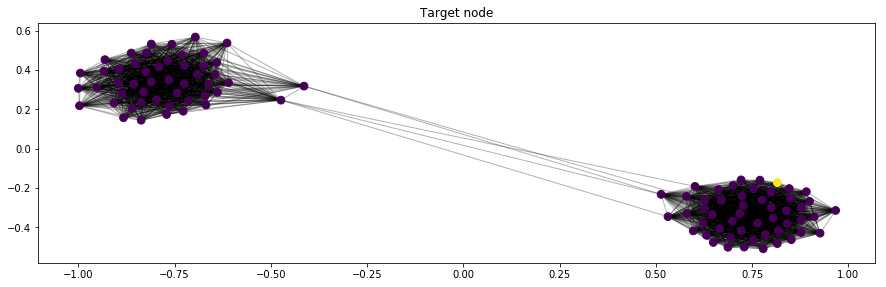

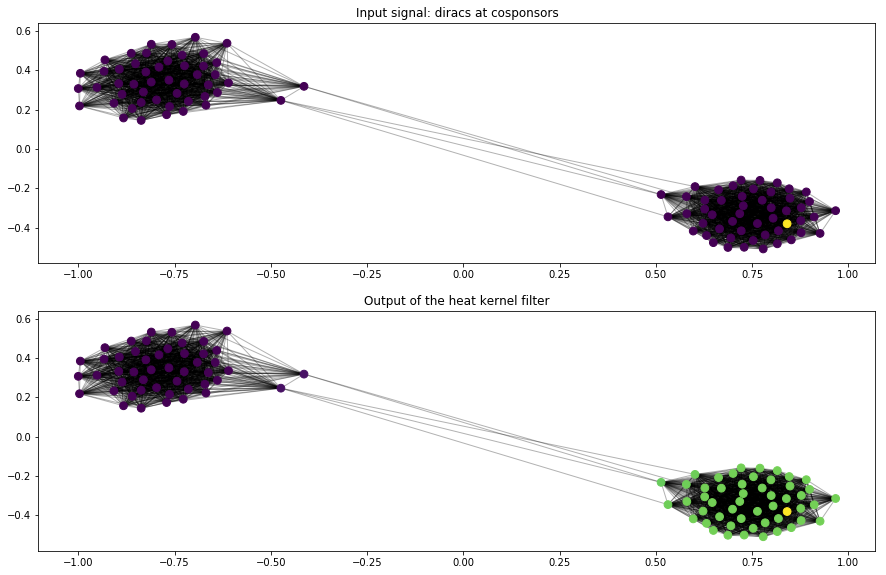

In [111]:
#Example
cosponsors_ex = [70]
e, U = scipy.linalg.eigh(nx.laplacian_matrix(graph).todense())
#Retrieve the distance
t = feature_heat_kernel_distance(5, cosponsors_ex, graph, 0.8, 0.01)
print(t)
#Illustrate the initial signal, and the signal after diffusion during time t
f_in = np.zeros(100)
f_in[cosponsors_ex] = 1

f_tar = np.zeros(100)
f_tar[5] = 1


#Plot
plt.figure(figsize= (15,15))
plt.subplot(311)
plt.title("Target node")
nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=f_tar)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.figure(figsize= (15,15))
plt.subplot(312)
plt.title("Input signal: diracs at cosponsors")
nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=f_in)
nx.draw_networkx_edges(graph, coords, alpha=0.3)

f_out = f_in
t = 0
while(f_out[5]<0.8*len(cosponsors_ex)):
    t = t + 0.01
    f_out = graph_filter(f_out, heat_kernel(e, 0.01), U)
    f_out[cosponsors_ex] = 1 #We assume that the heat generated at cosponsors is constant: they behave like heaters and don't lose their "heat" (ie. conviction in favor of the law)
    
print(t)
plt.subplot(313)
plt.title("Output of the heat kernel filter")
nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=f_out)
nx.draw_networkx_edges(graph, coords, alpha=0.3)

## 3 - Third feature: Committees

Another way to group senators is through the system of congressional commitees. A congressional committee is a sub-organization that handles a specific duty. Committee membership enables members to develop specialized knowledge of the matters under their jurisdiction. Congressional committees provide valuable informational services to Congress by investigating and reporting about specialized subjects, allowing for informed legislation.

Committees are of two forms in the senate: 
- "standing" commmittees
- "special" or "select" committees

There exists a third type of committee, bicameral, thus also grouping senators:
- "joint" committees

We fetch all standing and special committees from the API to get a list from their URIs, among other info.

In [21]:
with open("committee_members.json") as fp:
    committee_members = json.load(fp)

In [22]:
# Fetches the list of senators if it was not already loaded from before
if not "senators" in locals():
    senators = np.load("senatorActiveList.npy")
    print(f"Loaded {len(senators)} active senators.")

In [23]:
def map_senator_to_committees(senators_by_committee):
    committees_by_senator = {}
    for cmt_id, s_id_list in senators_by_committee.items():
        for s_id in s_id_list:
            if not s_id in committees_by_senator:
                committees_by_senator[s_id] = set()
            committees_by_senator[s_id].add(cmt_id)
    return committees_by_senator
        
cmts_by_s = map_senator_to_committees(committee_members)

In [24]:
print("There are", len(cmts_by_s.keys()), "individual senators with membership to >= 1 committee")

There are 98 individual senators with membership to >= 1 committee


In [25]:
# Creates a mapping senator_id -> senator_index in votes_results_matrix (alphabetical order of senator id)
s_ids = [s["id"] for s in senators]
s_index_from_id = {}
for s_index, s_id in enumerate(s_ids):
    s_index_from_id[s_id] = s_index
    
# Creates a function vote which gives the vote of some senator_id in some vote_id
def vote(senator_id, vote_id):
    return votes_results_matrix[vote_id][s_index_from_id[senator_id]]    


In [26]:
def avgvote_by_committee():
    avgvote_by_committee = {}
    for cmt_id, cmt_members in committee_members.items():
        print("Computing", votes_results_matrix.shape[1], "vote averages for committee", cmt_id)
        avgvote_by_committee[cmt_id] = {}
        for col in votes_results_matrix:
            # Computes avg vote of committee cmt_id in vote col
            votes = [v for v in [vote(senator_id, col) for senator_id in cmt_members] if not np.isnan(v)]            
            avgvote_by_committee[cmt_id][col] = sum(votes) / len(votes) if len(votes) > 0 else 0
    return avgvote_by_committee

avgvote_by_cmt = avgvote_by_committee()

NameError: name 'votes_results_matrix' is not defined

In [29]:
def avgvote(senator_id, vote_id):    
    my_committees = cmts_by_s.get(senator_id, [])
    vote_sum = 0    
    my_committees_votes = [v for v in [avgvote_by_cmt[cmt_id][vote_id] for cmt_id in my_committees] if not np.isnan(v)]
    #if any(v < 0 for v in my_committees_votes): print(my_committees_votes, vote_id)    
    return sum(my_committees_votes) / len(my_committees_votes) if len(my_committees_votes) > 0 else 0

avg_score_mat = np.zeros(votes_results_matrix.shape)

for vote_i, col in enumerate(votes_results_matrix):
    if vote_i % (votes_results_matrix.shape[1] // 10) == 0: print(vote_i, "votes computed.")
    for sen_i, senator in enumerate(senators):        
        avg_score_mat[sen_i, vote_i] = avgvote(senator["id"], col)

0 votes computed.
155 votes computed.
310 votes computed.
465 votes computed.
620 votes computed.
775 votes computed.
930 votes computed.
1085 votes computed.
1240 votes computed.
1395 votes computed.
1550 votes computed.


## N - Preparing the labels & features

In [121]:
def check_vote_validity(df_votes, vote_id, cosponsors_id):
    valid = False;

    #Check that we have senator cosponsors
    for senator_id in cosponsors_id:
        if senator_id in senator_ids:
            valid = True
    #Check that the vote is affiliated to a party
    vote_party = df_votes.loc[vote_id, "amendment.sponsor_party"]
    valid = valid and (vote_party in ('D','R'))
    
    return valid

In [126]:
#Generate a list of labels and features to be used by the linear classifier
labels = []
features= []

for vote_id in vote_ids:
    
    print("Working on vote", vote_id)
    bill_id = DFvotes.loc[vote_id, "bill.bill_id"]
    bill_cosponsors = cosponsors.get(bill_id, [])

    
    #Check if the vote will provide valid samples
    if check_vote_validity(DFvotes, vote_id, bill_cosponsors):
        print('Valid law')
        
        cosponsors_num = DFsenators.loc[bill_cosponsors, "id_num"].values #Retrieve cosponsors for that bill
        cosponsors_num = cosponsors_num[~np.isnan(cosponsors_num)]
        cosponsors_num=cosponsors_num.astype(int)
        print(cosponsors_num)
        for senator_id in senator_ids:
            senator_id_num = DFsenators.loc[senator_id, "id_num"]
            position = DFvote_positions.loc[senator_id_num, vote_id]
            #If this vote actually happened
            if not np.isnan(position):
                #Retrieve all the features for that vote/senator sample
                
                #Feature structure : laplacian_eigen_dim2 (party), ...
                feature = []
                
                #Co-vote features
                feature.append(feature_laplacian_eigen_dim2(fiedler, DFvotes, senator_id_num, vote_id))
                feature.append(feature_shortest_path(senator_id_num,cosponsors_num, graph))
                feature.append(feature_heat_kernel_distance(senator_id_num, cosponsors_num, graph, 0.3, 0.05))
                
                #Cosponsors features
                feature.append(feature_cosponsorship(adjacency_cospons, senator_id_num, cosponsors_num))
                feature.append(feature_shortest_path(senator_id_num,cosponsors_num, graph_cospons))
                feature.append(feature_heat_kernel_distance(senator_id_num, cosponsors_num, graph_cospons, 0.3, 0.05))
               
                #Committee features
                #feature.append(avgvote(senator_id, col)) # Problem here
                #feature.append( "une nouvelle feature" )

                #Append to the global features list
                labels.append(position)
                features.append(feature)
    else:
        print('Invalid law')
        
features = np.asarray(features)
np.save("features_full.npy",features)
np.save("labels_full.npy",labels)

Working on vote C115:S2:C274
Invalid law
Working on vote C115:S2:C273
Invalid law
Working on vote C115:S2:C272
Invalid law
Working on vote C115:S2:C271
Invalid law
Working on vote C115:S2:C270
Valid law
[96  6 17 71 46 90 65 98 92 80 52 51 16 15 72 93 95 59 83 77 66]


KeyboardInterrupt: 

In [125]:
features = np.load("features_full.npy")
labels = np.load("labels_full.npy")
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=common.SEED)


array([[1.78874065e-03, 3.98733447e+00, 1.00000000e+01, 8.56747981e+00,
        1.51497150e+00, 1.00000000e+01],
       [2.02387082e-01, 1.05472088e+00, 1.00000000e+01, 2.05364263e+00,
        2.78312775e+00, 1.00000000e+01],
       [1.77248872e-03, 4.11422411e+00, 1.00000000e+01, 1.02283202e+01,
        1.33204810e+00, 1.00000000e+01],
       ...,
       [1.77462626e-03, 4.28165088e+00, 1.00000000e+01, 1.99418563e+00,
        1.00124497e+00, 3.50000000e+00],
       [1.77462626e-03, 4.28165088e+00, 1.00000000e+01, 1.99418563e+00,
        1.00124497e+00, 3.50000000e+00],
       [1.98225374e-01, 4.28165088e+00, 1.00000000e+01, 1.99418563e+00,
        1.00124497e+00, 3.50000000e+00]])

## N+1 - The classifier

As using a classifier is not at the core of this course, we decided to go for a simple, off-the-shelf linear classifier : [Logistic Regression, from the sklearn package](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression).
One sample is a senator voting in favor of/against a law. 


In [92]:
#Fit the classifier to the data
clf = LogisticRegression(random_state=common.SEED, solver='liblinear')
clf.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=2018, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [93]:
#Compute the percentage of good classifications
score = clf.score(x_test, y_test)
print("Classifier score : " + str(score))


Classifier score : 0.7412140575079872


In [94]:
clfrf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=common.SEED)
clfrf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [95]:
score_te = clfrf.score(x_test, y_test)
score_tr = clfrf.score(x_train, y_train)
print("RandomForestClassifier test score : " + str(score_te))
print("RandomForestClassifier train score : " + str(score_tr))

RandomForestClassifier test score : 0.8019169329073482
RandomForestClassifier train score : 0.908315565031983
